In [92]:
import json
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

metrics = ["NDCG@k", "MAP@k", "Recall@k", "Precision@k", "MRR@k", "R_cap@k", "Hole@k", "Accuracy@k"]
datasets = ['trec-covid','nfcorpus','nq','hotpotqa','fiqa', 'webis-touche2020','dbpedia-entity','scidocs','fever','climate-fever','scifact']

def get_important_metrics(metrics: list):
    important_metrics = []
    for metric in metrics:
        if metric == "Precision@k":
            for k in [1,3,5,10]:
                important_metrics.append(f'P@{str(k)}')
        elif metric[:4] != 'Hole':
            for k in [1,3,5,10]:
                important_metrics.append(metric.replace('k',str(k)))
    return important_metrics
important_metrics = get_important_metrics(metrics)

def load_results(dataset: str):
    cfg = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)['chunker_config']
    results = [{'chunker': item[0]} | {'hyperparams': item[1]} for item in cfg]
    with open(f"results/eval_results_{dataset}.jsonl",'r') as f:
        for i, line in enumerate(f):
            result = json.loads(line)
            results[i].update(result)
    return results

def get_results_df(results: list):
    new_results = {}
    for item in results:
        temp = {}
        for metric in metrics:
            temp.update(item[metric])
        temp.update({'Latency': item['Latency']})
        key = item['chunker'] + '_' + '_'.join([k+'_'+str(v) for k,v in item['hyperparams'].items()])
        new_results[key] = temp
    return pd.DataFrame(new_results).T

def get_average_results():
    dfs = [get_results_df(load_results(dataset)) for dataset in datasets]
    return pd.concat(dfs).groupby(level=0).mean()

def get_best_config_per_chunker(df, keyword):
    idxs = [idx for idx in df.index if keyword in idx]
    df_sub = df.loc[idxs,important_metrics]
    return df_sub.index[df_sub.mean(axis=1).argmax()]

def get_hyperparam_comparison(df, hyperparam, default_method = None, exclude_methods = []):
    idxs = [idx for idx in df.index if hyperparam in idx or (default_method and idx == default_method)]
    if exclude_methods: idxs = [idx for idx in idxs if idx not in exclude_methods]
    return df.loc[idxs, important_metrics].sort_index()

def plot_metrics_cross_all_k(df, xargs = ['0', '0.25', '0.5', '0.75'], xlabel = 'lamda'):
    plot_metrics = ["NDCG", "MAP", "Recall", "P", "MRR", "R_cap", "Accuracy"]
    xticks = range(1,len(xargs)+1)
    for plot_metric in plot_metrics:
        cols = [column for column in df.columns if plot_metric in column]
        plt.plot(xticks, df[cols].mean(axis=1).tolist(), label=plot_metric)
    plt.xticks(xticks, xargs)
    # plt.yticks(yticks, yticks)
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.legend()
    plt.show()

# Method Comparison

In [93]:
get_average_results()

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@100,NDCG@1000,MAP@1,MAP@3,MAP@5,MAP@10,...,Hole@10,Hole@100,Hole@1000,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Accuracy@100,Accuracy@1000,Latency
cluster_chunker_mode_k-preserve,0.695985,0.696284,0.689480,0.696885,0.768407,0.784976,0.341423,0.500437,0.551702,0.612309,...,0.239997,0.405274,0.222986,0.723858,0.810909,0.829091,0.870455,0.969091,0.995455,17.101125
cluster_chunker_mode_k-preserve_lamda_0.25,0.696695,0.695584,0.689919,0.700440,0.769667,0.786253,0.342885,0.500573,0.553957,0.614497,...,0.242986,0.402845,0.227766,0.731760,0.804545,0.835000,0.886818,0.970000,0.997273,16.742761
cluster_chunker_mode_k-preserve_lamda_0.5,0.695985,0.696284,0.689480,0.696885,0.768407,0.784976,0.341423,0.500437,0.551702,0.612309,...,0.239997,0.405274,0.222986,0.723858,0.810909,0.829091,0.870455,0.969091,0.995455,17.109340
cluster_chunker_mode_k-preserve_lamda_0.75,0.694708,0.695003,0.691308,0.701104,0.769481,0.786723,0.343743,0.501740,0.554192,0.616051,...,0.239413,0.404674,0.219535,0.723124,0.803636,0.834545,0.880000,0.966364,0.995455,17.517957
cluster_chunker_mode_k-preserve_min_samples_2,0.706072,0.714427,0.711788,0.714409,0.782572,0.799105,0.361149,0.524570,0.578105,0.638568,...,0.220894,0.394255,0.170958,0.739033,0.801305,0.832215,0.857273,0.971818,0.994545,23.878834
cluster_chunker_mode_k-preserve_min_samples_4,0.716813,0.712298,0.708538,0.715187,0.784077,0.798986,0.358213,0.518155,0.571825,0.632652,...,0.225111,0.391823,0.189846,0.751364,0.806364,0.840455,0.885909,0.972727,0.995455,23.598901
cluster_chunker_mode_k-preserve_min_samples_6,0.695845,0.697075,0.695795,0.703865,0.771634,0.787531,0.341671,0.498426,0.553145,0.616011,...,0.227645,0.389488,0.206202,0.727156,0.806818,0.837273,0.880455,0.967273,0.995455,22.463439
cluster_chunker_mode_k-split_n_clusters_3,0.612179,0.582788,0.569825,0.567779,0.629755,0.667602,0.273292,0.397261,0.432163,0.478148,...,0.284697,0.411828,0.261832,0.641644,0.732215,0.765000,0.792273,0.919091,0.994545,8.098597
cluster_chunker_mode_k-split_n_clusters_3_n_sents_per_segment_3,0.617634,0.599408,0.591304,0.592507,0.659900,0.692830,0.276555,0.407056,0.447549,0.497292,...,0.270615,0.404982,0.253514,0.651189,0.742727,0.772273,0.811364,0.931818,0.996364,9.394235
cluster_chunker_mode_k-split_n_clusters_3_n_sents_per_segment_5,0.625728,0.604707,0.594597,0.604214,0.672361,0.702137,0.282686,0.416935,0.456561,0.512667,...,0.264677,0.397799,0.250415,0.664884,0.744091,0.774091,0.820909,0.943636,0.994545,9.714069


In [94]:
def get_method_comparison():
    df = get_average_results()
    best_k_preserve_idx = get_best_config_per_chunker(df, 'k-preserve')
    best_k_split_idx = get_best_config_per_chunker(df, 'k-split')
    best_sentence_idx = get_best_config_per_chunker(df, 'sentence')
    best_whole_idx = get_best_config_per_chunker(df, 'whole')
    best_word_idx = get_best_config_per_chunker(df, 'word')
    return df.loc[[best_k_preserve_idx, best_k_split_idx, best_sentence_idx, best_whole_idx, best_word_idx],important_metrics+['Latency']]

get_method_comparison()

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,MAP@1,MAP@3,MAP@5,MAP@10,Recall@1,Recall@3,...,MRR@10,R_cap@1,R_cap@3,R_cap@5,R_cap@10,Accuracy@1,Accuracy@3,Accuracy@5,Accuracy@10,Latency
cluster_chunker_mode_k-preserve_min_samples_4,0.716813,0.712298,0.708538,0.715187,0.358213,0.518155,0.571825,0.632652,0.358213,0.530824,...,0.788874,0.751364,0.742519,0.739687,0.756377,0.751364,0.806364,0.840455,0.885909,23.598901
cluster_chunker_mode_k-split_n_clusters_7,0.675670,0.663436,0.654715,0.656214,0.331077,0.481816,0.526061,0.575245,0.331077,0.496395,...,0.751601,0.707040,0.695941,0.684089,0.694311,0.707040,0.778007,0.819091,0.855000,12.505340
sentence_chunker_k_3,0.719284,0.716979,0.712431,0.723131,0.361383,0.523609,0.576410,0.638248,0.361383,0.537918,...,0.800661,0.759091,0.754033,0.745044,0.766262,0.759091,0.827727,0.857273,0.892727,22.773125
whole_chunker_,0.519342,0.482925,0.469582,0.466706,0.198330,0.295574,0.327064,0.370981,0.198330,0.315979,...,0.608055,0.555851,0.510470,0.496316,0.499324,0.555851,0.647727,0.674545,0.716818,4.589204
word_chunker_k_10,0.655390,0.656042,0.658215,0.672397,0.333152,0.475275,0.525477,0.587501,0.333152,0.494395,...,0.746339,0.695000,0.693691,0.698490,0.729323,0.695000,0.782727,0.819545,0.871364,38.765222


# Hyperparameter Comparison

## lamda

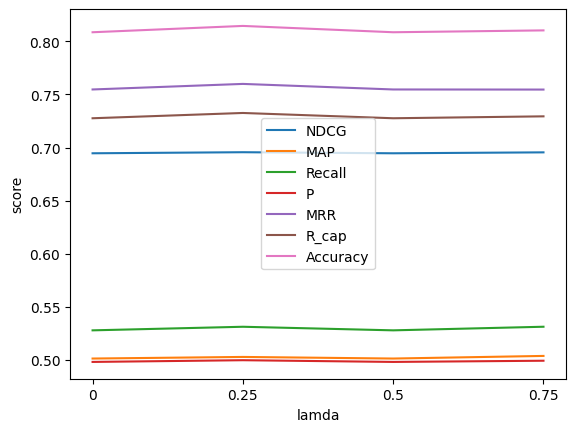

In [95]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'lamda', 'cluster_chunker_mode_k-preserve')
plot_metrics_cross_all_k(df, xargs = ['0', '0.25', '0.5', '0.75'], xlabel = 'lamda')

## min_samples

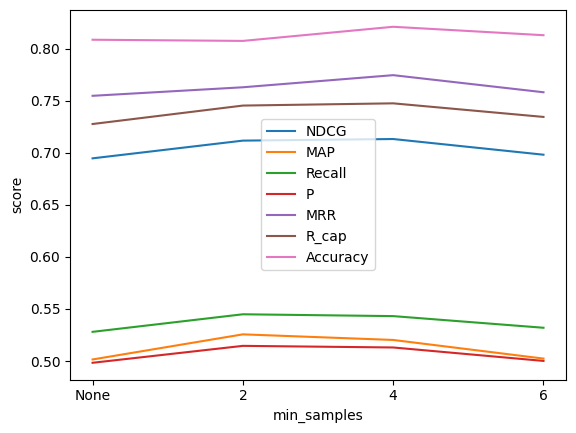

In [96]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'min_samples', 'cluster_chunker_mode_k-preserve')
plot_metrics_cross_all_k(df, xargs = ['None', '2', '4', '6'], xlabel = 'min_samples')

## n_clusters

The configs I use are not representative, considering that each long document consists of 8 short documents.

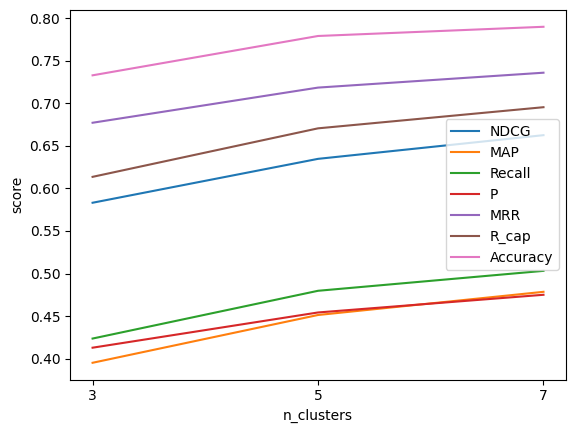

In [97]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'n_clusters', exclude_methods=['cluster_chunker_mode_k-split_n_clusters_3_n_sents_per_segment_3', 'cluster_chunker_mode_k-split_n_clusters_3_n_sents_per_segment_5'])
plot_metrics_cross_all_k(df, xargs = ['3', '5', '7'], xlabel = 'n_clusters')

## n_sents_per_segment

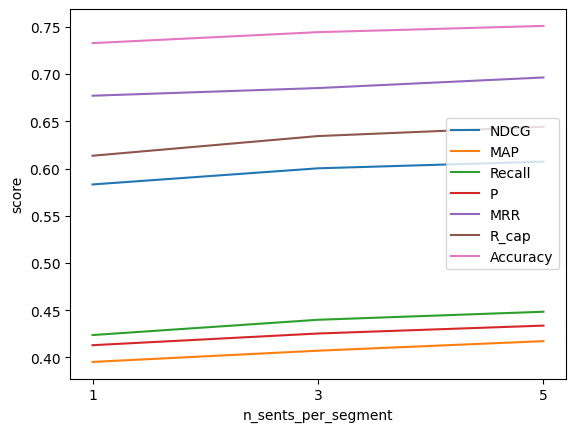

In [98]:
df = get_average_results()
df = get_hyperparam_comparison(df, 'n_sents_per_segment', default_method='cluster_chunker_mode_k-split_n_clusters_3')
plot_metrics_cross_all_k(df, xargs = ['1', '3', '5'], xlabel = 'n_sents_per_segment')